Hello World!

In [211]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# from sklearn_extra.cluster import KMedoids
from IPython.display import display

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE

from collections import Counter


##### Definiendo la funcion de carga de datos

In [116]:
class LoadImages:
    
    def __init__(self, root_path, files_names):
        self.root_path = root_path
        self.files_names = files_names
        
    def transform(self, X = None):
        img_files = []
        for file in self.files_names:
            img = cv2.imread(os.path.join(self.root_path, file)) #Carga la imagen Y DEVUELVE UN ARRAY
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # mantiene el sistema de colores RGC
            img_files.append(img)
        
        return img_files
    
    
class ResizeImages:
    
    def __init__(self, scale = 0.5):
        self.scale = scale
        
    def transform(self, img_files):
        img_files_resize = []
        for img in img_files:
            img = cv2.resize(img, (0, 0), fx = self.scale, fy = self.scale)
            img_files_resize.append(img)
        
        return img_files_resize

class ReshapeScaledImages:
        
    def transform(self, img_files_resize):
        img_files_reshape = []
        for img in img_files_resize:
            img = img.reshape((-1, 3))
            img = img / 255.0
            img_files_reshape.append(img)
        
        return img_files_reshape


In [ ]:
def elbow_plot(X, k_min=2, k_max=10):
    """
    Genera la gráfica para el método del codo usando KMeans sobre un conjunto X de pixeles.
    """
    inertias = []
    ks = range(k_min, k_max+1)
    for k in ks:
        kmeans = KMeans(n_clusters=k, max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    
    plt.plot(ks, inertias, marker='o')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Inercia (SSE)')
    plt.title('Método del codo (KMeans)')
    plt.grid()
    plt.show()

In [ ]:
def plot_kMeans_RGB(X, centroids):
    # Plot the colors and centroids in a 3D space
    X = X.reshape(-1,3)/255
    
    sample_size = int(0.01 * X.shape[0])
    sample_indices = np.random.choice(X.shape[0], sample_size, replace = False)
    X_sample = X[sample_indices]
    
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(221, projection='3d')
    ax.scatter(*X_sample.T*255, zdir='z', depthshade=False, s=.3, c=X_sample)
    ax.scatter(*centroids.T*255, zdir='z', depthshade=False, s=500, c='red', marker='x', lw=3)
    ax.set_xlabel('R value - Redness')
    ax.set_ylabel('G value - Greenness')
    ax.set_zlabel('B value - Blueness')
    ax.w_yaxis.set_pane_color((0., 0., 0., .2))
    ax.set_title("Original colors and their color clusters' centroids")
    plt.show()


In [ ]:
def plt_images_original_versus_segmentada(img_ori, img_seg):
    
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Imagen Original')
    plt.imshow(img_ori)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Imagen Segmentada')
    plt.imshow(img_seg.astype(np.uint8))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def tsne_distribution(img):
    tsne = TSNE(n_components = 2, perplexity=30, random_state=42)

    sample_size = int(0.01 * X.shape[0])
    sample_indices = np.random.choice(X.shape[0], sample_size, replace = False)
    X_sample = X[sample_indices]

    pixels_tsne = tsne.fit_transform(X_sample)

    plt.figure(figsize=(8, 6))
    plt.scatter(pixels_tsne[:, 0], pixels_tsne[:, 1], s=1, c=X_sample, marker="o")
    plt.axis("off")
    plt.title("t-SNE aplicado a la imagen")
    plt.show()


##### Funcion del Método del Codo: Clustering con K-Means

Usamos la función elbow_plot para determinar el número adecuado de clusters (k) en un conjunto de datos mediante el algoritmo K-Means. Para ello, evalúamos la inercia (SSE - Suma de los Errores Cuadráticos) para distintos valores de k, desde k_min hasta k_max, y genera una gráfica que muestra la relación entre el número de clusters y la inercia. El punto donde la curva comienza a disminuir más lentamente representa el valor óptimo de k, conocido como el "codo" de la gráfica. Esta técnica es ampliamente utilizada en aprendizaje no supervisado para seleccionar un número adecuado de clusters en problemas de clasificación.

In [ ]:
def show_palette(centroids, labels, title="Paleta de Colores"):
    """
    Muestra la paleta de colores obtenida por un algoritmo de clustering,
    ordenando los colores según su frecuencia de aparición.
    """
    counts = Counter(labels)
    # Ordenamos los centroides según mayor frecuencia
    total_pixels = sum(counts.values())
    
    # Lista de tuplas: (indice_cluster, frecuencia)
    freq_sorted = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    sorted_centroids = [centroids[idx] for idx, _ in freq_sorted]
    sorted_freqs = [counts[idx] for idx, _ in freq_sorted]
    
    # Mostramos la paleta
    plt.figure(figsize=(8, 2))
    plt.title(title, fontsize=14)
    
    start = 0
    for i, freq in enumerate(sorted_freqs):
        ratio = freq / total_pixels
        plt.barh([0], ratio, left=start, color=sorted_centroids[i])
        start += ratio
    plt.axis('off')
    plt.show()

In [209]:
def generate_color_palette(model, labels, title="Paleta de Colores"):
    """
    Genera una representación visual de la paleta de colores resultante tras la segmentación.
    Ordena los colores de mayor a menor frecuencia y agrega etiquetas con los valores RGB.

    Parámetros:
    -----------
    model : objeto de clustering (ej. KMeans, MeanShift)
        Debe tener un atributo 'cluster_centers_' con los centroides.
    labels : array-like
        Etiquetas de clúster asignadas a cada píxel.
    """
    centroids = model.cluster_centers_

    # Se cuenta la frecuencia de cada etiqueta
    label_counts = Counter(labels)
    total_pixels = sum(label_counts.values())

    # Se ordenan los colores por frecuencia
    freq_sorted = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_centroids = [centroids[idx] for idx, _ in freq_sorted]
    sorted_freqs = [label_counts[idx] for idx, _ in freq_sorted]

    # Crear figura más delgada y ancha
    fig, ax = plt.subplots(figsize=(8, 1))  
    plt.title(title, fontsize=10)

    left_position = 0
    for i, freq in enumerate(sorted_freqs):
        ratio = freq / total_pixels
        color_rgb = sorted_centroids[i]  # [R, G, B] en [0,1]
        
        # Dibujar barra de color
        ax.barh([0], ratio, left=left_position, color=color_rgb)

        # Calcular posición de la etiqueta (centrado en la barra)
        text_x = left_position + (ratio / 2)  # Centrar el texto dentro del color
        text_y = 0  # Centrado en la barra
        
        # Convertir valores a formato RGB [0,255]
        rgb_values = tuple(int(c * 255) for c in color_rgb)

        # Definir tamaño y ángulo de la fuente para evitar superposiciones
        font_size = max(6, 12 * ratio)  # Reducir fuente si el espacio es pequeño
        rotation_angle = 0  # Mantener horizontal
        
        # Agregar etiqueta con el color, verificando si hay suficiente espacio
        if ratio > 0.12:  # Solo poner texto si el espacio es suficiente
            ax.text(text_x, text_y, f"{rgb_values}", ha='center', va='center', 
                    fontsize=font_size, color='white' if sum(rgb_values) < 300 else 'black', 
                    rotation=rotation_angle, fontweight='bold')

        left_position += ratio

    ax.set_yticks([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.show()


Definicion del directorio Raiz

In [201]:
root_path = 'imagenes'
files_names = os.listdir(root_path)
files_names

['NAIVE_ART_PRIMITIVISM-aldemir-martins_macuna-ma-1982.jpg']

In [202]:
images = Pipeline(
    [
        ('load_images', LoadImages(root_path, files_names)),
        ('resize_images', ResizeImages(0.5))
    ]
)

processed_images = images.transform([])

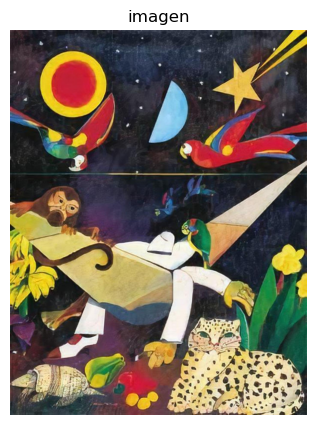

In [204]:
plt.figure(figsize=(10, 5))
plt.plot(1, 2, 1)
plt.title('imagen')
plt.imshow(processed_images[0])
plt.axis('off')
plt.show()

In [205]:
images_transform = Pipeline(
    [
        ('image_preprocessing', images),
        ('image_reshape', ReshapeScaledImages())
    ]
)

processed_images_transform = images_transform.transform([])

In [206]:
processed_images_transform[0]

array([[0.35686275, 0.28235294, 0.30588235],
       [0.35686275, 0.28235294, 0.30588235],
       [0.34509804, 0.27058824, 0.29411765],
       ...,
       [0.14901961, 0.18039216, 0.19215686],
       [0.18039216, 0.21176471, 0.22352941],
       [0.16862745, 0.2       , 0.21176471]])

Las dimensiones de la imagen original son correctas (ancho, alto, canales)

In [207]:
processed_images_transform[0].shape

(620518, 3)

 Las dimensiones del conjunto de entrenamiento son correctas (alto*ancho, canales)

In [14]:
X = processed_images_transform[0]          # Datos (pixeles normalizados)
original_shape = processed_images[0].shape


In [15]:
print("Dimensiones de X:", X.shape)  # (num_muestras, num_características)


Dimensiones de X: (2482072, 3)


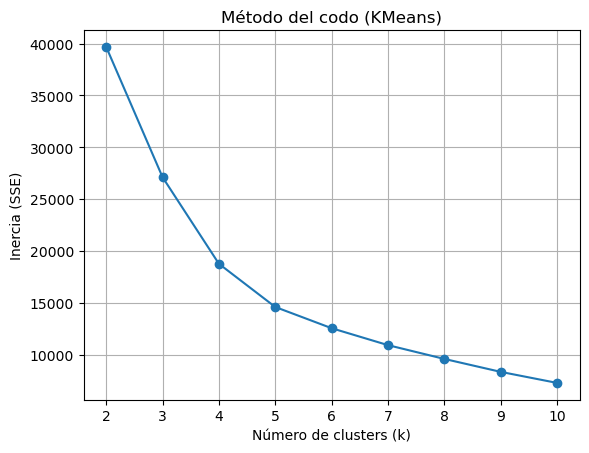

In [200]:
elbow_plot(processed_images_transform[0], 2, 10)


In [217]:
num_clusters = 6

In [ ]:
kmeans = KMeans(n_clusters=num_clusters, n_init=100, random_state=0)
kmeans.fit(X)

In [214]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_  # Estos son los colores en [0,1]
centroids

array([[0.28986897, 0.29810359, 0.28906153],
       [0.81911081, 0.71935073, 0.33810962],
       [0.88305442, 0.8675314 , 0.77966096],
       [0.14164279, 0.14735654, 0.16379839],
       [0.71016039, 0.21321962, 0.21106316]])

In [215]:
# Reemplazamos cada píxel por el centroide que le corresponde
img_segmented_kmeans = centroids[labels]

# Volvemos a [0,255]
img_segmented_kmeans = img_segmented_kmeans * 255

# Damos la forma original para poder visualizar
img_segmented_kmeans = img_segmented_kmeans.reshape(original_shape)


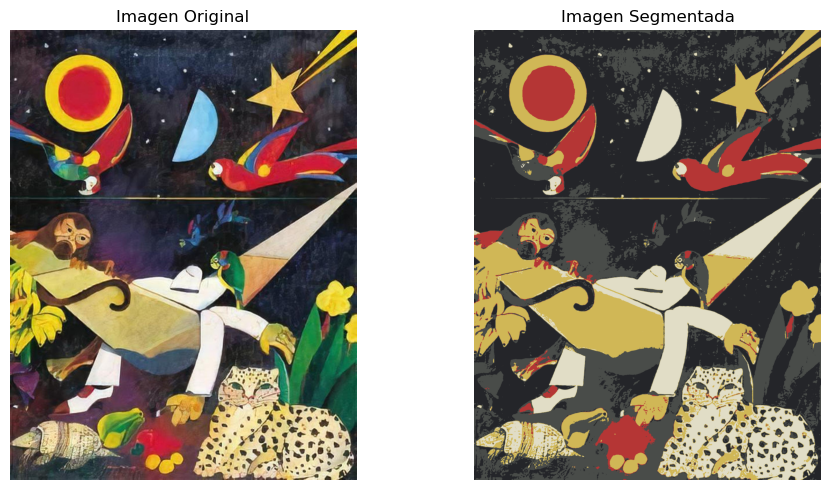

In [216]:
plt_images_original_versus_segmentada(img_original[0], img_segmented_kmeans)

Segmentación con Mean Shift

In [167]:
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=5000)  # samplea pixeles

In [168]:
meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
meanshift.fit(X)

MeanShift(bandwidth=0.24906900153547445, bin_seeding=True)

In [169]:
labels_ms = meanshift.labels_
centroids_ms = meanshift.cluster_centers_
centroids_ms

array([[0.17208945, 0.1696836 , 0.18967535],
       [0.83353536, 0.74007981, 0.45441369],
       [0.92353811, 0.87926638, 0.76443834],
       [0.72528517, 0.18088411, 0.2101571 ],
       [0.54063327, 0.78040182, 0.90867527]])

In [170]:
img_segmented_ms = centroids_ms[labels_ms] * 255
img_segmented_ms = img_segmented_ms.reshape(original_shape)

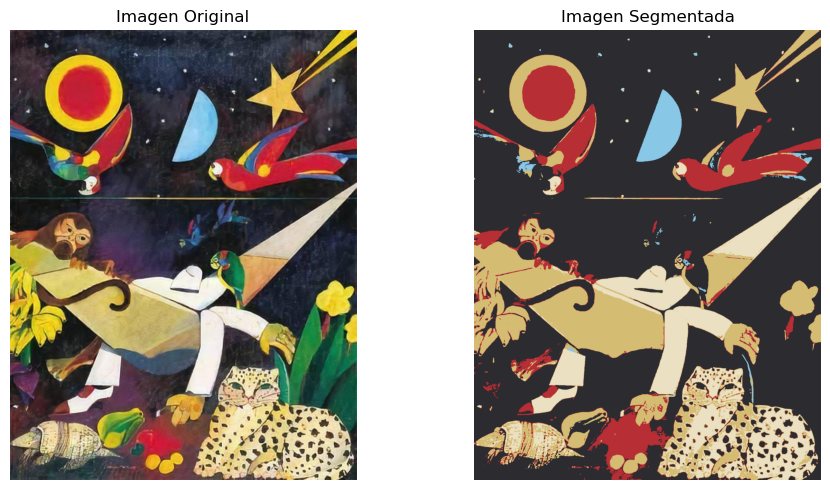

In [196]:

plt_images_original_versus_segmentada(img_original[0], img_segmented_ms)

##### Extracción de la Paleta de Colores

Para mostrar la paleta resultante (por ejemplo, la de KMeans), podemos:

1. Contar la frecuencia de cada clúster en labels.
2. Ordenar de mayor a menor frecuencia.
3. Graficar los colores en rectángulos.



C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6948\2968060872.py:16: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((0., 0., 0., .2))


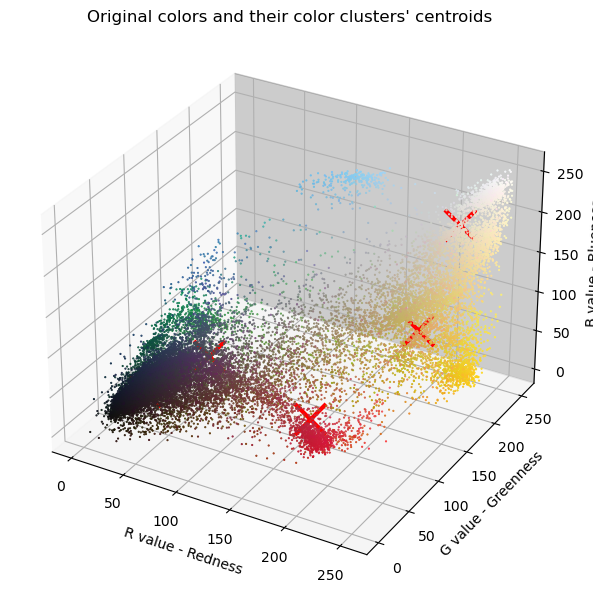

In [188]:
plot_kMeans_RGB(img_original[0], centroids)

Alternativa con codigos de color

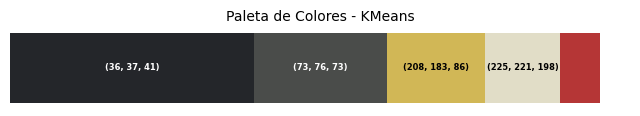

In [212]:
# Ejecutar la función para generar la paleta de colores
generate_color_palette(kmeans, kmeans.labels_, title="Paleta de Colores - KMeans")


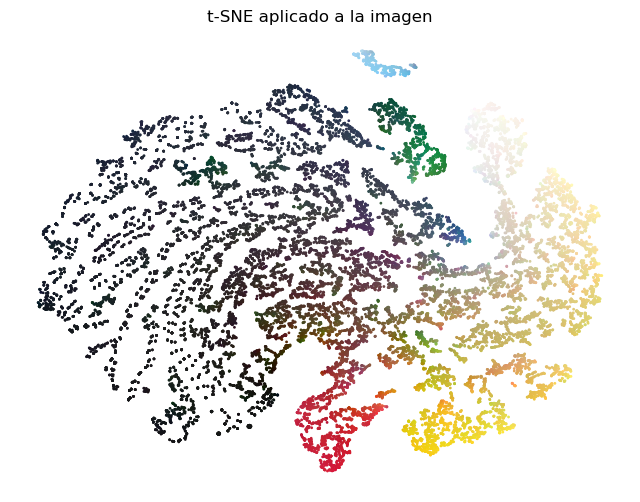

In [199]:
tsne_distribution(X)

In [ ]:
def 